# AuxTel Plot tracking - 29-Oct-21

In this notebook, investigate again mount tracking on 29-Oct-21\
This is after the EFD was converted to UTC.\
Thanks to Simon Krughoff for contributions.

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from astropy.time import Time, TimeDelta
from lsst.daf.butler import Butler

In [2]:
from lsst_efd_client import EfdClient
from lsst_efd_client import  __version__ as efdVersion
print(efdVersion)

__version__ = '0.10.1'


In [4]:
# Get EFD client and the butler
client = EfdClient('summit_efd')
butler = Butler('/repo/LATISS', collections="LATISS/raw/all")

In [5]:
# Get one header data using Gen3 butler
# This confirms that the DATE_BEG and DATE_END timestamps remain in TAI, as specified.

expId = 2022030800018
mData = butler.get('raw.metadata', detector=0, exposure=expId)
print(f"{expId} \t {mData['TIMESYS']} \t {mData['DATE']} \t {mData['DATE-BEG']} \t {mData['DATE-END']}")

2022030800018 	 TAI 	 2022-03-08T17:32:36.181 	 2022-03-08T17:33:00.320 	 2022-03-08T17:33:10.559


In [6]:
# Need to convert DATE_BEG and DATE_END to UTC to sync up with the EFD
date_beg = Time(mData['DATE-BEG'], format='isot', scale='tai')
date_end = Time(mData['DATE-END'], format='isot', scale='tai')
print(date_beg.utc, date_end.utc)
print(date_beg.tai, date_end.tai)

2022-03-08T17:32:23.320 2022-03-08T17:32:33.559
2022-03-08T17:33:00.320 2022-03-08T17:33:10.559


In [7]:
# Use these for finding the "allAxesInPosition" timestamp
# The inPosition timestamp makes sense with the DATE-BEG and DATE-END times
before = 10.0
after = 30.0
if expId < 2021101300000:
    # EFD was switched to UTC on 20211013
    tai_offset = 37.0
else:
    tai_offset = 0.0

start = date_beg.utc - TimeDelta(before, format='sec') + TimeDelta(tai_offset, format='sec')
end = date_end.utc + TimeDelta(after, format='sec') + TimeDelta(tai_offset, format='sec')
print(start, end)

inPosition = await client.select_time_series("lsst.sal.ATMCS.logevent_allAxesInPosition", "inPosition", start, end)
inPosition = inPosition[inPosition['inPosition']==True] 
print(inPosition)

2022-03-08T17:32:13.320 2022-03-08T17:33:03.559
                                  inPosition
2022-03-08 17:32:20.139000+00:00        True


In [8]:
# Use these for finding the shutter status timestamp
# The inPosition timestamp makes sense with the DATE-BEG and DATE-END times
# They agree within a few milliseconds.
before = 5.0
after = 30.0
inPos = Time(inPosition.index[0])
tstart = inPos - TimeDelta(before, format='sec')
tend = inPos + TimeDelta(after, format='sec')

shutter = await client.select_time_series("lsst.sal.ATCamera.logevent_shutterDetailedState", "substate", tstart, tend)

# These match within msec with the DATE-BEG and DATE-END timestamps in the header,
# after we have converted DATE_END and DATE_BEG to UTC
print(shutter)
print(shutter.index[0], date_beg.utc)
shutter_open = shutter.index[0]
try:
    shutter_close = shutter.index[1]
    print(shutter.index[1], date_end.utc)
except:
    shutter_close = shutter.index[0] + pd.Timedelta(seconds=mData['EXPTIME'])
    print(shutter_close, date_end.utc)

                                  substate
2022-03-08 17:32:23.350000+00:00         2
2022-03-08 17:32:33.551000+00:00         1
2022-03-08 17:32:23.350000+00:00 2022-03-08T17:32:23.320
2022-03-08 17:32:33.551000+00:00 2022-03-08T17:32:33.559


In [12]:
# Now get the mount tracking info for a time before and after the inPosition timestamp.
doOffset = True # This takes out the time offset.  It's a bit of a fudge

before = 30.0
after = 30.0
inPos = Time(inPosition.index[0])
tstart = inPos - TimeDelta(before, format='sec')
tend = inPos + TimeDelta(after, format='sec')

print(f"{inPos} \t {tstart} \t {tend}")
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
az_target = await client.select_time_series("lsst.sal.ATMCS.logevent_target", "azimuth",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)
el_target = await client.select_time_series("lsst.sal.ATMCS.logevent_target", "elevation",  tstart, tend)
if doOffset:
    offset = (tstart.jd - az.index[0].to_julian_date()) * 86400.0
    az.index += pd.DateOffset(seconds=offset)
    el.index += pd.DateOffset(seconds=offset)

print(f"Tstart={tstart}, Start of dataFrame = {az.index[0]}, {az_target.index[0]}")

2022-03-08 17:32:20.139000 	 2022-03-08 17:31:50.139000 	 2022-03-08 17:32:50.139000
Tstart=2022-03-08 17:31:50.139000, Start of dataFrame = 2022-03-08 17:31:50.138993927, 2022-03-08 17:31:55.796000+00:00


In [13]:
#az_target = await client.select_time_series("lsst.sal.ATMCS.logevent_target",["azimuth", "taiTime"],  tstart, tend)
az_target = await client.select_time_series("lsst.sal.ATMCS.logevent_target","azimuth",  tstart, tend)

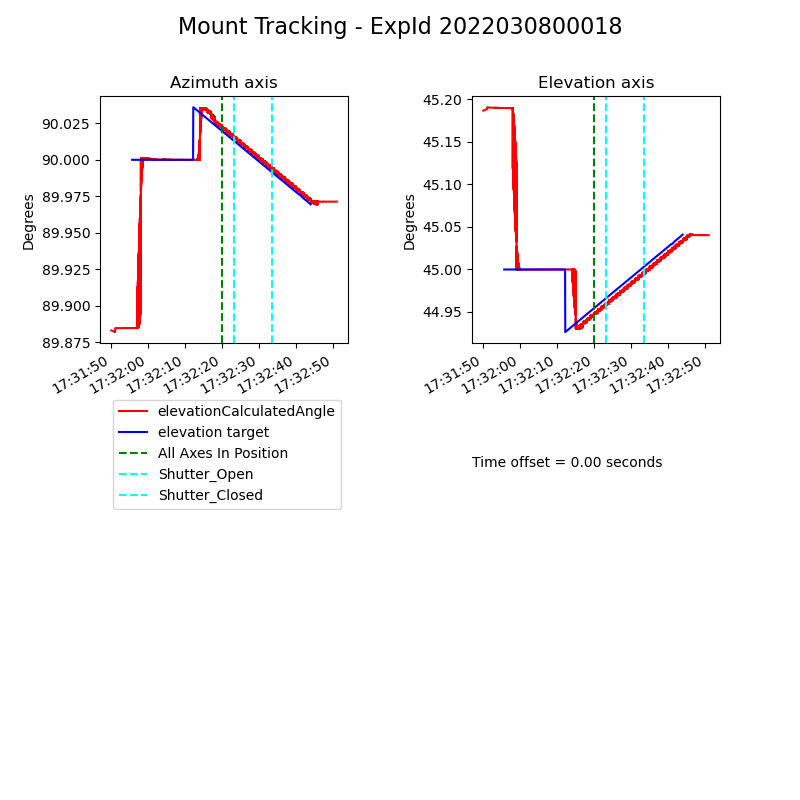

In [14]:
# Plot it
az_target_vals = np.array(az_target.values.tolist())[:,0]
az_target_times = np.array(az_target.index.tolist())
el_target_vals = np.array(el_target.values.tolist())[:,0]
el_target_times = np.array(el_target.index.tolist())

fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5)
plt.suptitle(f"Mount Tracking - ExpId {expId}", fontsize = 16)
# Azimuth axis
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(color='red')
ax1.plot(az_target_times, az_target_vals, label='azimuth target', color='blue')
ax1.set_title("Azimuth axis", fontsize=12)
ax1.axvline(inPosition.index[0], color="green", linestyle="--", label="All Axes In Position")
ax1.axvline(shutter_open, color='cyan', linestyle="--", label="Shutter_Open")
ax1.axvline(shutter_close, color='cyan', linestyle="--", label="Shutter_Closed")
ax1.set_ylabel("Degrees")
#ax1.legend(loc='lower left')
# Elevation axis
plt.subplot(2,2,2)
ax2 = el['elevationCalculatedAngle'].plot(legend=True, color='red')
ax2.plot(el_target_times, el_target_vals, label='elevation target', color='blue')
ax2.set_title("Elevation axis", fontsize=12)
ax2.axvline(inPosition.index[0], color="green", linestyle="--", label="All Axes In Position")
ax2.axvline(shutter_open, color='cyan', linestyle="--", label="Shutter_Open")
ax2.axvline(shutter_close, color='cyan', linestyle="--", label="Shutter_Closed")
ax2.set_ylabel("Degrees")
ax2.legend(bbox_to_anchor=(-0.5, -0.2))
offset = (tstart.jd - az.index[0].to_julian_date()) * 86400.0
ax2.text(0.0,-0.5, f"Time offset = {offset:.2f} seconds", transform=ax2.transAxes)

plt.savefig(f"/home/craiglagegit/DATA/mount_graphs/Tracking_Timebase_{expId}_17Mar22.pdf")
